# I. Exploration

## 1. Data Loading and Visualisation

First we load some useful libraries for data loading and data visualization in Python

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

from math import *

In [2]:
def Load_DataSet(name, data_location = "data/"):
    return pd.read_csv(data_location + name + ".txt", sep = " ")

In [31]:
# Data loading
path = ""
data_location = "data/"
rain = Load_DataSet("rain_project", data_location = path + data_location)
# Let's take a look at the data
rain.head()

,Id,date,ff,t,td,hu,dd,precip,ws_arome,p3031_arome,u10_arome,v10_arome,t2m_arome,d2m_arome,r_arome,tp_arome,msl_arome,rain,rain_class
1,22092001_527,2017-06-11,3.945000,289.408750,285.277083,78.783333,246.750000,0.0,3.663785,244.299500,3.038503,1.416360,289.232315,285.170885,79.037785,2.328277,101672.850,0.2,low_rain
2,22092001_65,2016-03-06,3.739583,276.375833,273.422500,81.700000,260.333333,1.2,3.328476,305.660752,2.463886,-1.898971,275.808688,273.672591,86.331598,10.675441,100583.760,4.2,high_rain
3,22092001_210,2016-07-29,3.273750,288.869167,286.723333,87.620833,259.041667,0.2,3.232380,256.042392,2.963872,0.985627,289.627425,286.485126,82.301031,4.582309,101482.984,0.0,no_rain
4,22092001_136,2016-05-16,1.745000,284.288750,280.215833,76.587500,216.541667,0.0,1.720926,139.297271,-0.260693,-1.397603,284.726139,280.367340,75.384116,0.940254,102223.586,0.0,no_rain
5,22092001_33,2016-02-03,5.718750,277.527917,274.529167,81.391667,285.541667,1.6,4.424012,285.578800,3.940056,-1.457606,277.751699,274.590656,80.435085,13.903076,102416.220,0.0,no_rain


**Remark**:

In this database, we realise that the qualitative variables including "Id", "date", "rain_class". 

The other variables are considered quantitative including "ff","t", "td", "hu", "dd", "precip", "ws_arome", "p3031_arome", "u10_arome", "v10_arome", "t2m_arome", "d2m_arome", "r_arome", "tp_arome", "msl_arome", "rain"

## Data transformation

### Date to month

In [4]:
#Replace the column "date" into "month" to obtain the new data
from datetime import datetime, timedelta

rain["date"] = pd.to_datetime(rain["date"]).dt.month
rain = rain.rename(columns= {"date":"month"})

In [5]:
names = list(rain.columns)
num_var = names[2:-1]
qual_var = [names[i] for i in [0,1,-1]]

### Logarithm transformation ($\log(\cdot + 1)$)

In [6]:
rain_log = rain.copy()

rain_log["precip"] = np.log(rain_log["precip"] + 1)
rain_log["tp_arome"] = np.log(rain_log["tp_arome"] + 1)
rain_log["rain_log"] = np.log(rain_log["rain"] + 1)

rain_log.rename(columns = {'precip':'precip_log', 'tp_arome':'tp_arome_log'}, inplace = True)

# num_var += ["rain_log"]

### Month class

In [7]:
rain_class = pd.get_dummies(rain, columns =  ['month'])
rain_log_class = pd.get_dummies(rain_log, columns =  ['month'])

### Spliting the data into a training set and a test set

In [8]:
def SplitingData(train_set_rate = .8, random = False):
    if not(random):
        limit_train_test_set = ceil(train_set_rate*rain.shape[0])

        rain_train = rain.iloc[limit_train_test_set:, :]
        rain_test = rain.iloc[:limit_train_test_set, :]
    
    else:
        rain_train = rain.sample(frac = train_set_rate)
        rain_test = rain.drop(rain_train.index)
    return (rain_train, rain_test)

train_set_rate = .8 # 80 %
rain_train, rain_test = SplitingData(train_set_rate, random = False)

In [9]:
print(rain_train.head())
print(rain_train.describe())

               Id  month        ff           t          td         hu  \
584   22092001_45      2  4.679583  275.466250  271.397083  74.733333   
585  22092001_301     10  3.213750  282.306250  281.397500  94.241667   
586  22092001_677     11  4.611667  279.261250  274.905000  74.100000   
587  22092001_472      4  3.319167  281.765417  279.520000  87.000000   
588  22092001_247      9  4.012500  291.472083  290.456250  93.937500   

             dd  precip  ws_arome  p3031_arome  u10_arome  v10_arome  \
584  194.666667     0.0  4.633919   122.667345  -0.544019  -4.495519   
585   81.291667     0.2  2.437694    77.091818  -2.002213  -1.150413   
586  325.083333     0.0  4.157488   335.756474   1.599636  -3.711660   
587  261.125000     0.2  3.320934   210.137176   0.682416  -2.778765   
588  251.291667     1.2  3.989500   245.573278   3.499476   1.579636   

      t2m_arome   d2m_arome    r_arome  tp_arome   msl_arome  rain rain_class  
584  275.610739  272.128872  77.073972  1.006348

In [10]:
print(rain_test.head())
print(rain_test.describe())

             Id  month        ff           t          td         hu  \
1  22092001_527      6  3.945000  289.408750  285.277083  78.783333   
2   22092001_65      3  3.739583  276.375833  273.422500  81.700000   
3  22092001_210      7  3.273750  288.869167  286.723333  87.620833   
4  22092001_136      5  1.745000  284.288750  280.215833  76.587500   
5   22092001_33      2  5.718750  277.527917  274.529167  81.391667   

           dd  precip  ws_arome  p3031_arome  u10_arome  v10_arome  \
1  246.750000     0.0  3.663785   244.299500   3.038503   1.416360   
2  260.333333     1.2  3.328476   305.660752   2.463886  -1.898971   
3  259.041667     0.2  3.232380   256.042392   2.963872   0.985627   
4  216.541667     0.0  1.720926   139.297271  -0.260693  -1.397603   
5  285.541667     1.6  4.424012   285.578800   3.940056  -1.457606   

    t2m_arome   d2m_arome    r_arome   tp_arome   msl_arome  rain rain_class  
1  289.232315  285.170885  79.037785   2.328277  101672.850   0.2   low_r

## PCA

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [12]:
pcaR = PCA()
loadingR = pd.DataFrame(scale(rain[num_var]), columns = rain[num_var].columns)
pca_DataSet = pcaR.fit(loadingR).transform(loadingR)

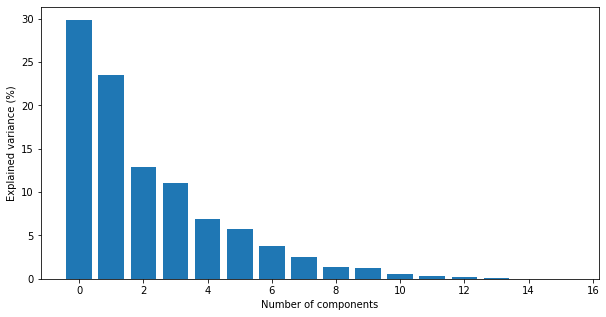

In [17]:
plt.figure(figsize = (10,5))
x = np.arange(pcaR.explained_variance_ratio_.size)
plt.bar(x, pcaR.explained_variance_ratio_*100)
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.show()

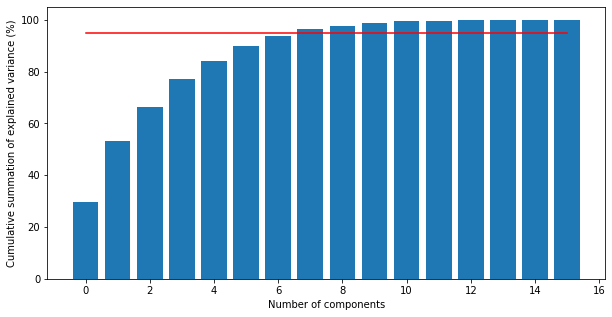

In [21]:
plt.figure(figsize = (10,5))
x = np.arange(pcaR.explained_variance_ratio_.size)
plt.bar(x, pcaR.explained_variance_ratio_.cumsum()*100)
plt.plot(x, np.zeros(x.shape)+95, color  ="red")
plt.xlabel('Number of components')
plt.ylabel('Cumulative summation of explained variance (%)')
plt.show()

In [23]:
nb_PCA_components = 7

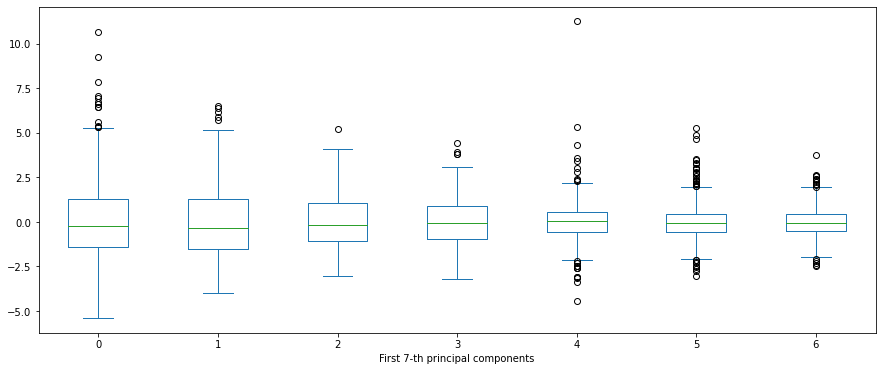

In [26]:
pd.DataFrame(pca_DataSet[:,0:nb_PCA_components]).plot(kind = "box", figsize = (15, 6) )
plt.xlabel('First %d-th principal components' % nb_PCA_components)
plt.show()

In [38]:
class_of_rain.value_counts()

low_rain     292
no_rain      208
high_rain    188
Name: rain_class, dtype: int64

KeyError: 7

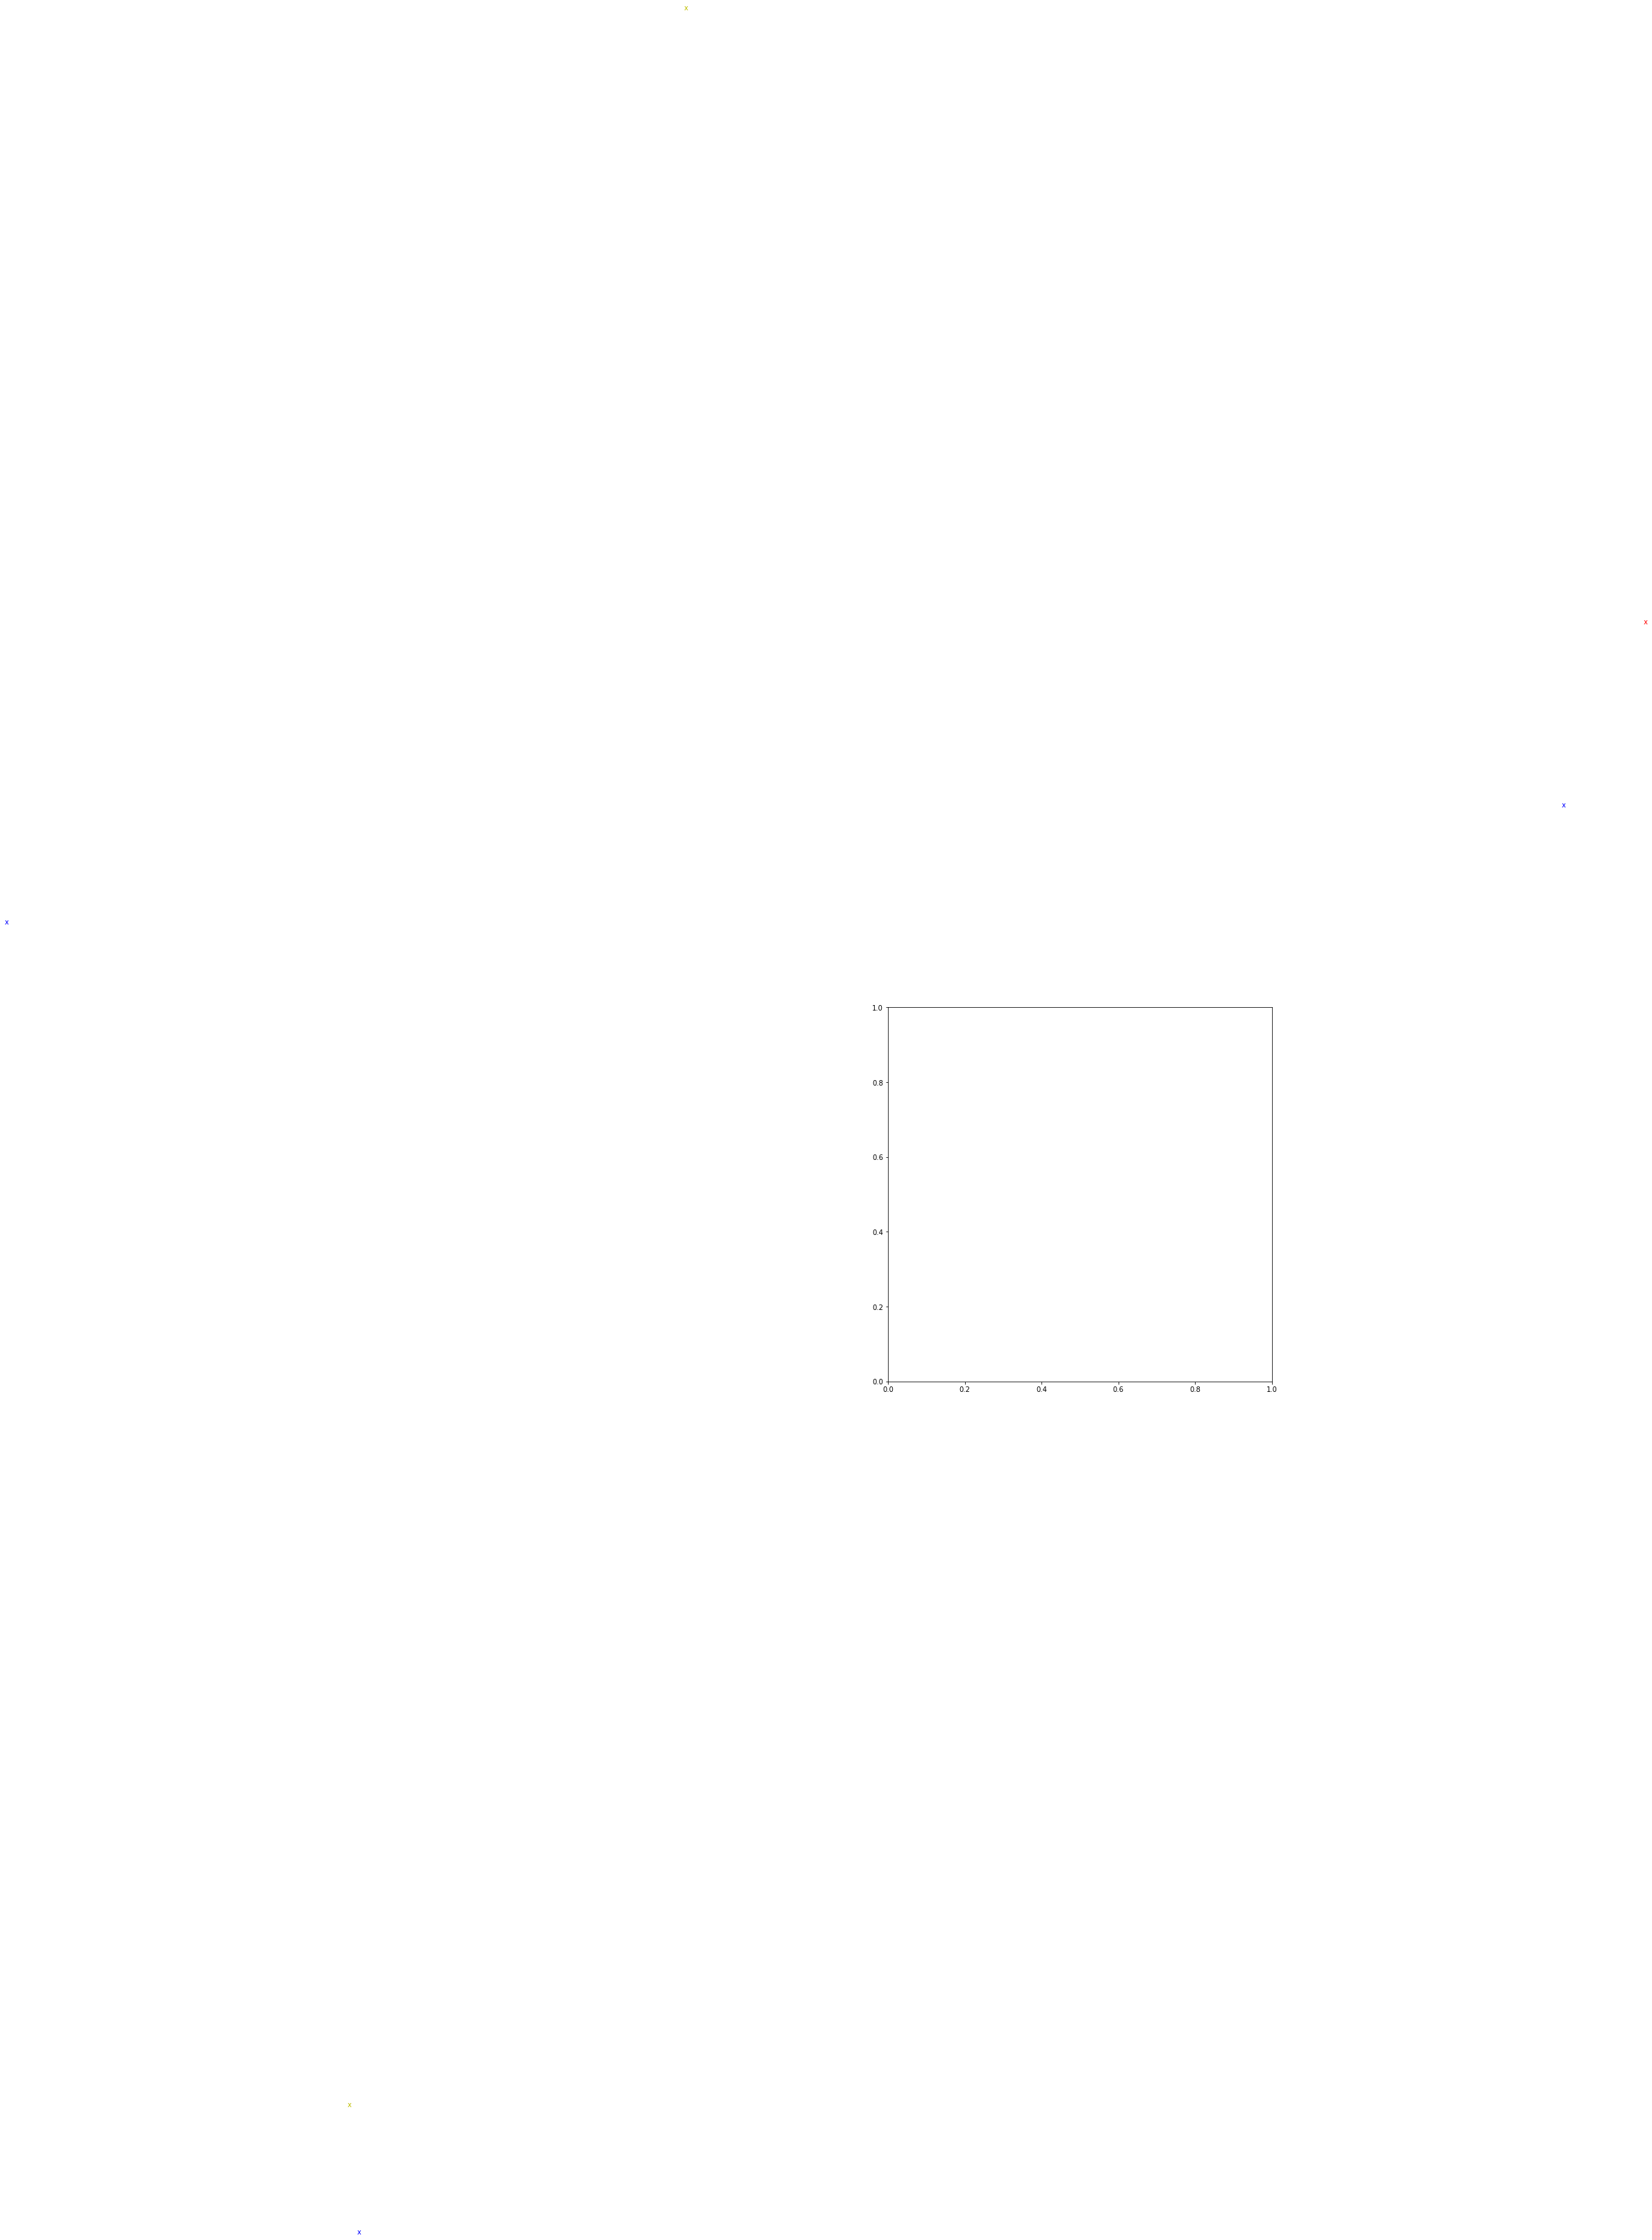

In [40]:
pc1 = pca_DataSet[:,0]
pc2 = pca_DataSet[:,1]
class_of_rain = rain['rain_class'].astype("category")
index = 1
plt.figure(figsize = (10, 10))
for i, j in zip(pc1, pc2):
    if class_of_rain[index] == "no_rain":
        plt.text(i, j, "x", c="blue")
    elif class_of_rain[index] == "low_rain":
        plt.text(i, j, "x", c="y")
    else:
        plt.text(i, j, "x", c="r")
    index+=1 
plt.plot([], [], 'x',color="blue", label="No rain")
plt.plot([], [], 'x',color="y", label="Low rain")
plt.plot([], [], 'x',color="r", label="High rain")
plt.legend()
# plt.axis((-15, 25, -20, 20))
plt.title('Individuals factor map - PCA')
plt.show()

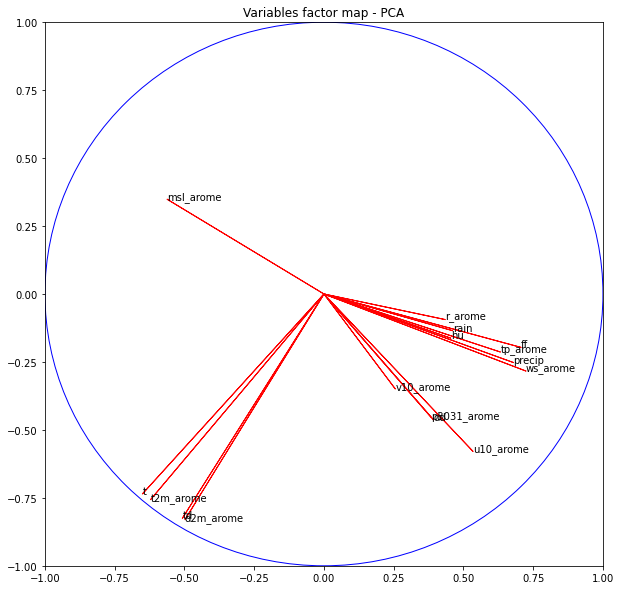

In [41]:
coord1 = pcaR.components_[0] * np.sqrt(pcaR.explained_variance_[0])
coord2 = pcaR.components_[1] * np.sqrt(pcaR.explained_variance_[1])
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1, coord2, loadingR.columns):
    plt.text(i, j, nom)
    plt.arrow(0, 0, i, j, color = 'r', width = 0.0001)
plt.axis((-1, 1, -1, 1))
#Cercle
c = plt.Circle((0, 0), radius = 1, color = 'b', fill = False)
ax.add_patch(c)
plt.title('Variables factor map - PCA')
plt.show()

## Saves data sets

In [14]:
def Save_DataSet(df, name, data_location = "data/"):
    df.to_csv(data_location + name + ".txt", sep = " ")

In [15]:
Save_DataSet(rain_train, "train_set")
Save_DataSet(rain_test, "test_set")